In [1]:
import numpy as np
import random

class Network(object):
    
    def __init__(self):
        
        self.num_layers = 0
        self.sizes = []
        self.biases = []
        self.weights = []
        self.test_result_massages = []
        
    def generate_network_after_structure(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def getBiases(self):
        return self.biases
    
    def setBiases(self, biases):
        self.biases = biases
        
    def getWeights(self):
        return self.weights
    
    def setWeights(self, weights):
        self.weights = weights
    
    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z)*(1-self.sigmoid(z))

    def feedforward(self, a):
        
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+ b)

        return a

    def feedforward_learning(self, activation):

        zs = []
        activations = [activation]

        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        return zs, activations

    def backpropgation(self, input_test, expected_result):

        delta_partial_bias = [np.zeros(b.shape) for b in self.biases]
        delta_partial_weights = [np.zeros(w.shape) for w in self.weights]

        zs, activations = self.feedforward_learning(input_test)
        
        a = activations[-1] - expected_result
        b = self.sigmoid_prime(zs[-1])
        
        delta = a * b
            
        delta_partial_bias[-1] = delta
        delta_partial_weights[-1] = np.dot(delta, activations[-2].transpose())
        
        for i in range(2, self.num_layers):
            z = zs[-i]
            
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-i+1].transpose(), delta) * sp
            
            delta_partial_bias[-i] = delta
            delta_partial_weights[-i] = np.dot(delta, activations[-i-1].transpose())
            
        return delta_partial_bias, delta_partial_weights

    def update_mini_batch(self, mini_batch, eta):

        new_bias = [np.zeros(b.shape) for b in self.biases]
        new_weights = [np.zeros(w.shape) for w in self.weights]
        
        for input_test, expected_result in mini_batch:
            delta_bias, delta_weights = self.backpropgation(input_test, expected_result)
            
            new_bias = [n_b + d_b for n_b, d_b in zip(new_bias, delta_bias)]
            new_weights = [n_w + d_w for n_w, d_w in zip(new_weights, delta_weights)]

        self.biases = [b - ( eta/len(mini_batch))* n_b
                       for b, n_b in zip(self.biases, new_bias)]

        self.weights = [w - (eta/len(mini_batch))* n_w
                        for w, n_w in zip(self.weights,  new_weights)]

    def SGD_random_shuffle(self, training_data, epochs, mini_batch_size, eta, test_data = None):
        
        n = len(training_data)
        
        for i in range(epochs):
            
            random.shuffle(training_data)
            mini_batches = [training_data[j : j + mini_batch_size]
                            for j in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            if test_data:
                self.test_result_massages.append(str("Epoch: " + str(i) +" result: " + str(self.evaluate_function(test_data))))
                
    def SGD_linear_testing(self, training_data, epochs, mini_batch_size, eta, test_data = None):
        
        n = len(training_data)
        linear_size = int(n/epochs)
        
        for i in range(epochs):
            
            batch_begin = random.randint(1, linear_size - mini_batch_size)
            mini_batches = [training_data[j : j + mini_batch_size] for j in range(i*linear_size+batch_begin, i*linear_size+batch_begin+mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            if test_data:
                self.test_result_massages.append(str("Epoch: " + str(i) +" result: " + str(self.evaluate_function(test_data))))
                    
    def SGD_uniform_testing(self, training_data, epochs, mini_batch_size, eta, test_data = None):
        
        n = len(training_data)
        
        mini_batches = [training_data[j : j + mini_batch_size] for j in range(0, n, mini_batch_size)]
        
        for i in range (epochs):
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

                if test_data:
                    self.test_result_massages.append(str("Epoch: " + str(i) +" result: " + str(self.evaluate_function(test_data))))

            
    def evaluate_function(self, test_data):
        test_results  = [(self.feedforward(x), y)
                        for (x, y) in test_data]
        
        test_efficiency = [x - y
                          for (x, y) in test_results]
        
        return sum(test_efficiency)/len(test_data)
        
        
    def evaluate(self, test_data):
        
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        
        return sum(int(x == y) for (x, y) in test_results)

    def print_test_result_massages(self):
        for massages in self.test_result_massages:
            print(massages)
    
    def print_network(self):
        for i in range(self.num_layers - 1):
            for (b, w) in zip(self.weights[i], self.biases[i]):
                print(w,' ',b,)
            print()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from PIL import Image
from sklearn import metrics

In [3]:
def creat_batches(source_img, size_x, size_y, classification, nr_classes):

    all_batches = []
    n = len(classification)

    for i in range(n):
        
        val = classification[i]
        
        if not np.isnan(val):
            try:
                img_name = classification.index[i].strftime('%Y-%m-%d') + '.png'
                img = Image.open(source_img + img_name).convert('L')
                img_resized = img.resize((size_x, size_y))
                img_array = np.array(img_resized)
                img_array = img_array/255

                input_data = []
                for row in img_array:
                    for pixel in row:
                        input_data.append([pixel])

                output_data = []
                for j in range(nr_classes):
                    output_data.append([0])

                output_data[int(val)][0] = 1

                all_batches.append((np.array(input_data),np.array(output_data)))
                
            except FileNotFoundError as e:
                continue

    return all_batches

In [32]:
def max_pos(x):
    p = 0
    for i in range(1,len(x)):
        if x[i]>x[p]:
            p = i
    
    return p

def calc_efficiency_even(test_batches, changes, net):
    
    x = len(test_batches)
    k = len(test_batches[0][1])
    
    real_res = []
    pred_res = []
    
    market_pred = []
    market_real = []
    
    exact = 0
    distance = 0
    
    mid_only = 0
    mid_db = 0
    
    base_pred  = 1000
    base_real  = 1000
    
    for i in range(0, x):
        real = max_pos(test_batches[i][1])
        pred = max_pos(net.feedforward(test_batches[i][0]))
        
        real_res.append(real)
        pred_res.append(pred)
        
        if real == pred:
            exact += 1
        
        distance += 1/(1 + abs(real - pred))
        
        if real == k/2 - 1 or real == k/2:
            mid_db += 1
            if real == pred:
                mid_only += 1
        
        base_real += base_real * changes[i]
        
        if pred >= k/2:
            base_pred += base_pred * changes[i]
        
        market_real.append(base_real)
        market_pred.append(base_pred)
        
    
    exact = exact*100/x
    print(exact)
    distance = distance*100/x
    mid_only = mid_only*100/mid_db
    
    return real_res, pred_res, exact, distance, mid_only, market_real, market_pred

def calc_efficiency_odd(test_batches, changes, net):
    
    x = len(test_batches)
    k = len(test_batches[0][1])
    
    real_res = []
    pred_res = []
    
    market_pred_g = []
    market_pred_ge = []
    market_real = []
    
    exact = 0
    distance = 0
    
    mid_only = 0
    mid_db = 0
    
    base_pred_g  = 1000
    base_pred_ge  = 1000
    base_real  = 1000
    
    for i in range(0, x):
        real = max_pos(test_batches[i][1])
        pred = max_pos(net.feedforward(test_batches[i][0]))
        
        real_res.append(real)
        pred_res.append(pred)
        
        if real == pred:
            exact += 1
        
        distance += 1/(1 + abs(real - pred))
        
        if real == k//2:
            mid_db += 1
            if real == pred:
                mid_only += 1
        
        base_real += base_real * changes[i]
        
        if pred > k//2:
            base_pred_g += base_pred_g * changes[i]
            
        if pred >= k//2:
            base_pred_ge += base_pred_ge * changes[i]
        
        
        market_real.append(base_real)
        market_pred_g.append(base_pred_g)
        market_pred_ge.append(base_pred_ge)
    
    exact = exact*100/x
    print(exact)
    distance = distance*100/x
    mid_only = mid_only*100/mid_db
    
    return real_res, pred_res, exact, distance, mid_only, market_real, market_pred_g, market_pred_ge

In [5]:
source_img = "E:/SZAKDOLGOZAT/KUTATAS/IMAGE_GEN/UBS/images_21/Gramian_Angular/gray/"
source_classes = "E:/SZAKDOLGOZAT/KUTATAS/CLASSIFICATION/UBS_fully_classified.csv"

ubs_all_classes = pd.read_csv(source_classes, index_col = "Date", parse_dates = True)
ubs_c = ubs_all_classes['1_day_even_6class']

In [6]:
batches01 = creat_batches(source_img, 21, 21, ubs_c, 6)

In [7]:
training_batches01 = batches01[:-252]
test_batches01 = batches01[-252:]

In [8]:
print(len(batches01))
print(len(training_batches01))
print(len(test_batches01))

5735
5483
252


In [9]:
net01 = Network()
net01.generate_network_after_structure([441, 100, 50, 6])

In [10]:
net01.SGD_random_shuffle(training_batches01, 600, 10, 3.0)

In [33]:
ubs_changes = pd.read_csv("E:/SZAKDOLGOZAT/KUTATAS/CLASSIFICATION/UBS_fully_classified.csv", index_col = "Date", parse_dates = True)
changes = ubs_changes['Open'].pct_change(periods = 1).fillna(0).tail(252).values
real_res01, pred_res01, exact01, distance01, mid_only01, market_real01, market_pred01 = calc_efficiency_even(test_batches01, changes, net01)

35.317460317460316


exact precision:          35.317460317460316
distance base precision:  64.61640211640211
mid only precision:       45.54973821989529

market finnish:           1062.531750760832
predicted finnish:        1201.9766103877766

market performance:       5.34273920257065
win rate to start:        20.197661038777664
win rate to market:       13.123829902221216


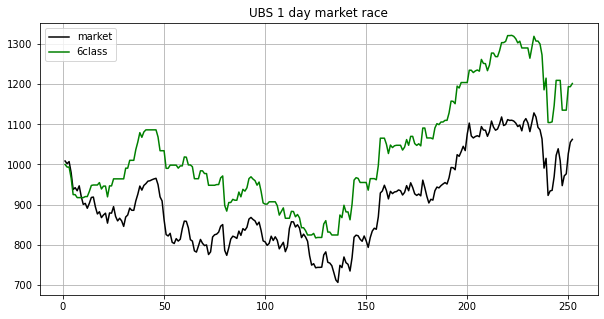

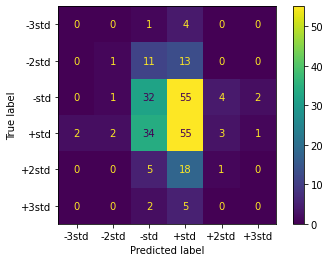

In [34]:
market_start = ubs_changes['Open'].tail(252).head(1).values[0]
market_end = ubs_changes['Open'].tail(1).values[0]

finnish_real01 = market_real01[251]
finnish_pred01 = market_pred01[251]

print("exact precision:         ", exact01)
print("distance base precision: ", distance01)
print("mid only precision:      ", mid_only01)
print()
print("market finnish:          ", finnish_real01)
print("predicted finnish:       ", finnish_pred01)
print()
print("market performance:      ", (market_end-market_start)*100/market_start)
print("win rate to start:       ", (finnish_pred01-1000)/10)
print("win rate to market:      ", (finnish_pred01-finnish_real01)*100/finnish_real01)

fig, ax = plt.subplots(figsize=(10, 5))
x = len(test_batches01)

plt.grid(visible = True)
plt.title("UBS 1 day market race")
plt.plot(np.linspace(1,x,x), market_real01, color = '#000000', label = 'market')
plt.plot(np.linspace(1,x,x), market_pred01, color = 'green', label = '6class')
plt.legend()

confusion_matrix01 = metrics.confusion_matrix(real_res01, pred_res01)
cm_display01 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix01, display_labels = ["-3std", "-2std","-std","+std", "+2std", "+3std"])
#cm_display01.ax_.set_title('DIS 6class confusion matrix')
cm_display01.plot()
plt.show()

In [40]:
n = len(training_batches01)
exact01_train = 0

for i in range(0, n):
        real = max_pos(training_batches01[i][1])
        pred = max_pos(net01.feedforward(training_batches01[i][0]))
        
        
        if real == pred:
            exact01_train += 1
print("Training precision 6class:", (exact01_train/n)*100)

Training precision 6class: 75.5425861754514


In [13]:
ubs_c2 = ubs_all_classes['1_day_even_4class']
batches02 = creat_batches(source_img, 21, 21, ubs_c2, 4)
training_batches02 = batches02[:-252]
test_batches02 = batches02[-252:]

In [14]:
net02 = Network()
net02.generate_network_after_structure([441, 100, 50, 4])

In [15]:
net02.SGD_random_shuffle(training_batches02, 600, 10, 3.0)

In [35]:
ubs_changes = pd.read_csv("E:/SZAKDOLGOZAT/KUTATAS/CLASSIFICATION/UBS_fully_classified.csv", index_col = "Date", parse_dates = True)
changes02 = ubs_changes['Open'].pct_change(periods = 1).fillna(0).tail(252).values
real_res02, pred_res02, exact02, distance02, mid_only02, market_real02, market_pred02 = calc_efficiency_even(test_batches02, changes02, net02)

35.317460317460316


exact precision:          35.317460317460316
distance base precision:  65.24470899470901
mid only precision:       44.50261780104712

market finnish:           1062.531750760832
predicted finnish:        1201.8700616383092

market performance:       5.34273920257065
win rate to start:        20.187006163830915
win rate to market:       13.113802084286249


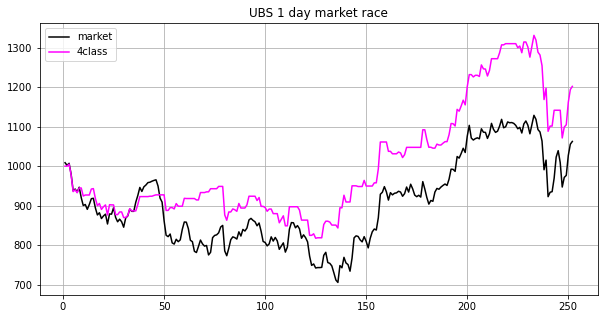

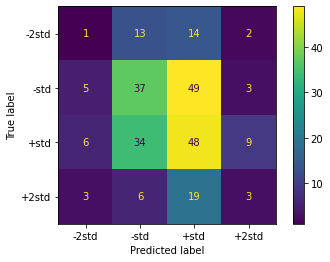

In [36]:
market_start = ubs_changes['Open'].tail(252).head(1).values[0]
market_end = ubs_changes['Open'].tail(1).values[0]

finnish_real02 = market_real02[251]
finnish_pred02 = market_pred02[251]

print("exact precision:         ", exact02)
print("distance base precision: ", distance02)
print("mid only precision:      ", mid_only02)
print()
print("market finnish:          ", finnish_real02)
print("predicted finnish:       ", finnish_pred02)
print()
print("market performance:      ", (market_end-market_start)*100/market_start)
print("win rate to start:       ", (finnish_pred02-1000)/10)
print("win rate to market:      ", (finnish_pred02-finnish_real02)*100/finnish_real02)

fig, ax = plt.subplots(figsize=(10, 5))
x = len(test_batches02)

plt.grid(visible = True)
plt.title("UBS 1 day market race")
plt.plot(np.linspace(1,x,x), market_real02, color = '#000000', label = 'market')
plt.plot(np.linspace(1,x,x), market_pred02, color = 'magenta', label = '4class')
plt.legend()

confusion_matrix02 = metrics.confusion_matrix(real_res02, pred_res02)
cm_display02 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix02, display_labels = ["-2std","-std","+std", "+2std"])
#cm_display02.set_title('DIS 4class confusion matrix')
cm_display02.plot()
plt.show()

In [41]:
n = len(training_batches02)
exact02_train = 0

for i in range(0, n):
        real = max_pos(training_batches02[i][1])
        pred = max_pos(net02.feedforward(training_batches02[i][0]))
        
        
        if real == pred:
            exact02_train += 1
            
print("Training precision 4class: ", (exact02_train/n)*100)

Training precision 4class:  81.81652380083897


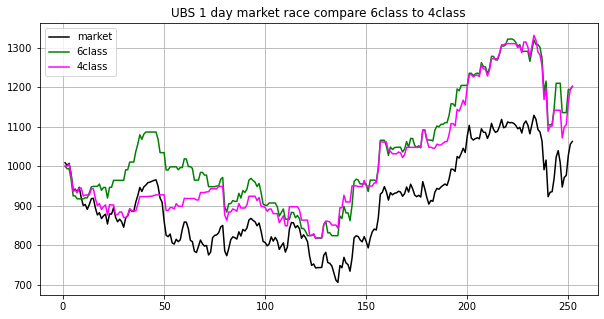

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.grid(visible = True)
plt.title("UBS 1 day market race compare 6class to 4class")
plt.plot(np.linspace(1,x,x), market_real01, color = '#000000', label = 'market')
plt.plot(np.linspace(1,x,x), market_pred01, color = 'green', label = '6class')
plt.plot(np.linspace(1,x,x), market_pred02, color = 'magenta', label = '4class')
plt.legend()

In [44]:
print((finnish_pred01-finnish_pred02)/10)
print((finnish_pred02-finnish_pred01)/10)

0.01065487494674926
-0.01065487494674926


In [23]:
ubs_c3 = ubs_all_classes['1_day_odd_3class']
batches03 = creat_batches(source_img, 21, 21, ubs_c3, 3)

training_batches03 = batches03[:-252]
test_batches03 = batches03[-252:]

In [24]:
net03 = Network()
net03.generate_network_after_structure([441, 100, 50, 3])

In [25]:
net03.SGD_random_shuffle(training_batches03, 600, 10, 3.0)

In [37]:
ubs_changes = pd.read_csv("E:/SZAKDOLGOZAT/KUTATAS/CLASSIFICATION/UBS_fully_classified.csv", index_col = "Date", parse_dates = True)
changes03 = ubs_changes['Open'].pct_change(periods = 1).fillna(0).tail(252).values
real_res03, pred_res03, exact03, distance03, mid_only03, market_real03, market_pred_g03, market_pred_ge03 = calc_efficiency_odd(test_batches03, changes03, net03)

34.92063492063492


exact precision:          34.92063492063492
distance base precision:  65.34391534391536
mid only precision:       42.4

market finnish:           1062.531750760832
predicted finnish g:        1127.5645397268047
predicted finnish ge:        806.0317588317715

win rate to start g:       12.75645397268047
win rate to start ge:       -19.39682411682285

market performance:       5.34273920257065
win rate to market g:       6.120550178326964
win rate to market ge:       -24.140454320107814


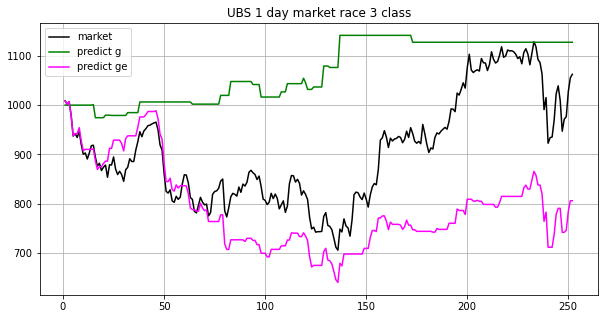

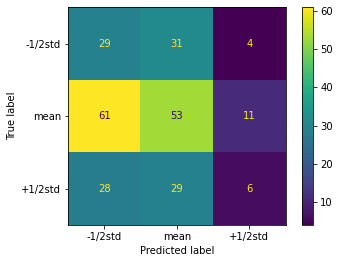

In [46]:
market_start = ubs_changes['Open'].tail(252).head(1).values[0]
market_end = ubs_changes['Open'].tail(1).values[0]

finnish_real03 = market_real03[251]
finnish_pred_g03 = market_pred_g03[251]
finnish_pred_ge03 = market_pred_ge03[251]

print("exact precision:         ", exact03)
print("distance base precision: ", distance03)
print("mid only precision:      ", mid_only03)
print()
print("market finnish:          ", finnish_real03)
print("predicted finnish g:       ", finnish_pred_g03)
print("predicted finnish ge:       ", finnish_pred_ge03)
print()
print("win rate to start g:      ", (finnish_pred_g03-1000)/10)
print("win rate to start ge:      ", (finnish_pred_ge03-1000)/10)
print()
print("market performance:      ", (market_end-market_start)*100/market_start)
print("win rate to market g:      ", (finnish_pred_g03-finnish_real02)*100/finnish_real03)
print("win rate to market ge:      ", (finnish_pred_ge03-finnish_real02)*100/finnish_real03)

fig, ax = plt.subplots(figsize=(10, 5))
x = len(test_batches03)

plt.grid(visible = True)
plt.title("UBS 1 day market race 3 class")
plt.plot(np.linspace(1,x,x), market_real03, color = '#000000', label = 'market')
plt.plot(np.linspace(1,x,x), market_pred_g03, color = 'green', label = 'predict g')
plt.plot(np.linspace(1,x,x), market_pred_ge03, color = 'magenta', label = 'predict ge')
plt.legend()

confusion_matrix03 = metrics.confusion_matrix(real_res03, pred_res03)
cm_display03 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix03, display_labels = ["-1/2std", "mean", "+1/2std"])
#cm_display03.ax_.set_title('DIS 3class confusion matrix')
cm_display03.plot()
plt.show()

In [39]:
n = len(training_batches03)
exact03_train = 0

for i in range(0, n):
        real = max_pos(training_batches03[i][1])
        pred = max_pos(net03.feedforward(training_batches03[i][0]))
        
        if real == pred:
            exact03_train += 1
            
print("Training precision 3class: ", (exact03_train/n)*100)

Training precision 3class:  67.99197519606055


In [43]:
print((finnish_pred_g03-finnish_pred_ge03)/10)
print((finnish_pred_ge03-finnish_pred_g03)/10)

32.15327808950332
-32.15327808950332


In [47]:
print(pred_res01)
print()
print(pred_res02)
print()
print(pred_res03)

[2, 4, 2, 3, 3, 0, 4, 2, 2, 2, 3, 2, 3, 4, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 4, 4, 4, 3, 2, 1, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 2, 0, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 1, 3, 2, 5, 2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 5, 3, 3, 3, 2, 3, 3, 1, 2, 3, 3, 3, 2, 2, 4, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 5, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2, 3]

[0, 0, 3, 2, 2, 2, 2, 2, 1, 2, 3, 1, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 3, 2, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 3, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 3

In [48]:
f = open("E:/SZAKDOLGOZAT/KUTATAS/NN_21/UBS/6class/biases.txt", "w")
biases = net01.getBiases()
for b in biases:
    f.write(str(b))
    f.write(str('\n'))
f.close()


f = open("E:/SZAKDOLGOZAT/KUTATAS/NN_21/UBS/6class/weights.txt", "w")
weights = net01.getWeights()
for we in weights:
    for w in we:
        f.write(str(w))
        f.write(str('\n'))
    f.write(str('\n'))
f.close()

####################################################################################################
f = open("E:/SZAKDOLGOZAT/KUTATAS/NN_21/UBS/4class/biases.txt", "w")
biases = net02.getBiases()
for b in biases:
    f.write(str(b))
    f.write(str('\n'))
f.close()


f = open("E:/SZAKDOLGOZAT/KUTATAS/NN_21/UBS/4class/weights.txt", "w")
weights = net02.getWeights()
for we in weights:
    for w in we:
        f.write(str(w))
        f.write(str('\n'))
    f.write(str('\n'))
f.close()

####################################################################################################
f = open("E:/SZAKDOLGOZAT/KUTATAS/NN_21/UBS/3class/biases.txt", "w")
biases = net03.getBiases()
for b in biases:
    f.write(str(b))
    f.write(str('\n'))
f.close()


f = open("E:/SZAKDOLGOZAT/KUTATAS/NN_21/UBS/3class/weights.txt", "w")
weights = net03.getWeights()
for we in weights:
    for w in we:
        f.write(str(w))
        f.write(str('\n'))
    f.write(str('\n'))
f.close()